In [8]:
%load_ext autoreload
%autoreload 2
# %matplotlib widget

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
import xarray as xr
import numpy as np
import pandas as pd

import ecephys_analyses as ea 

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

In [10]:
xr.set_options(keep_attrs=True)

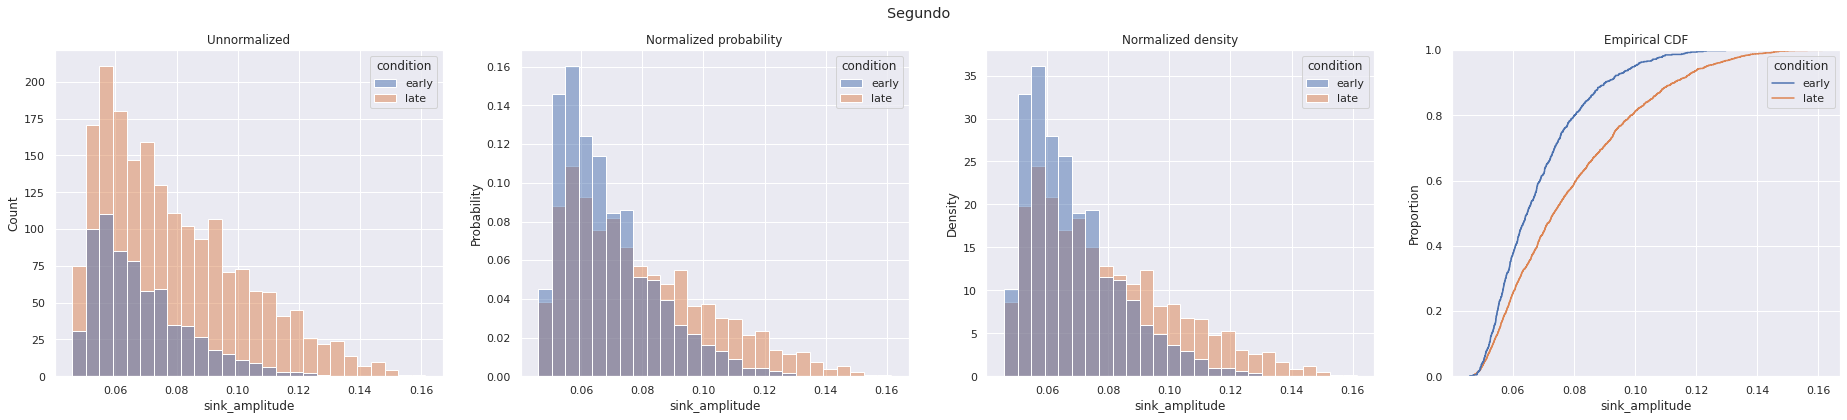

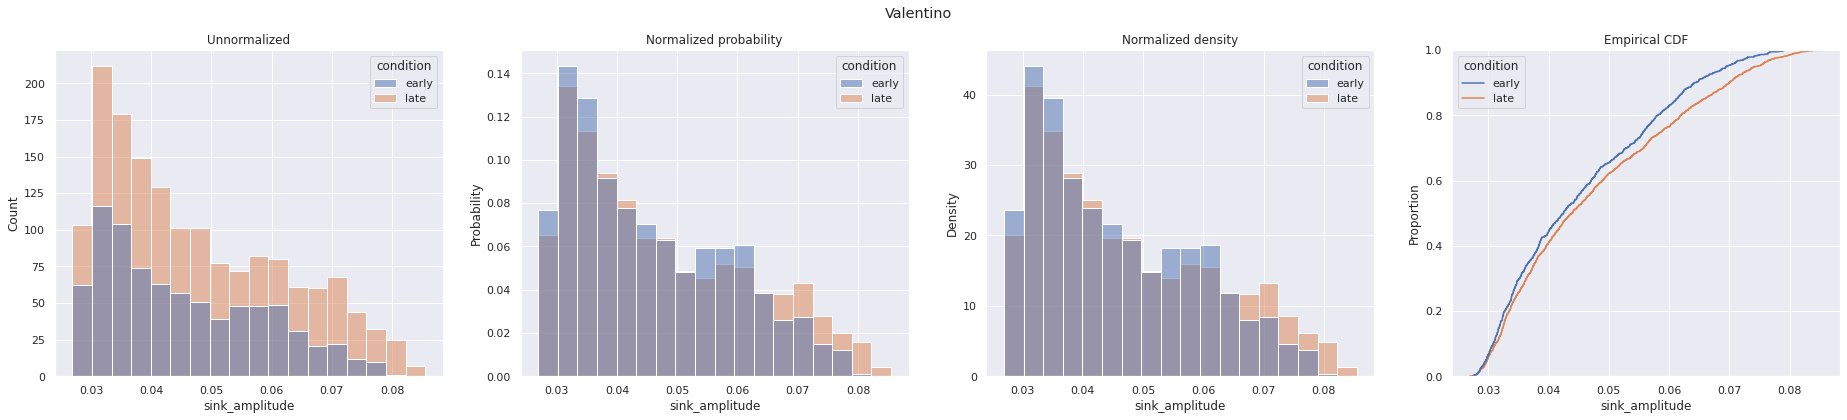

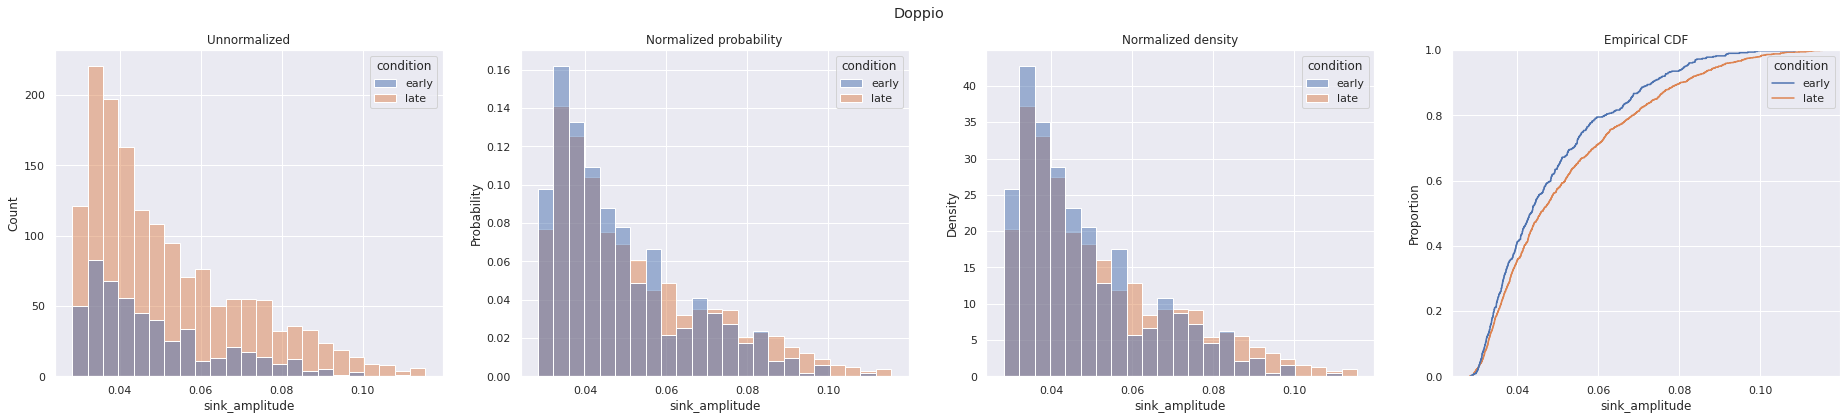

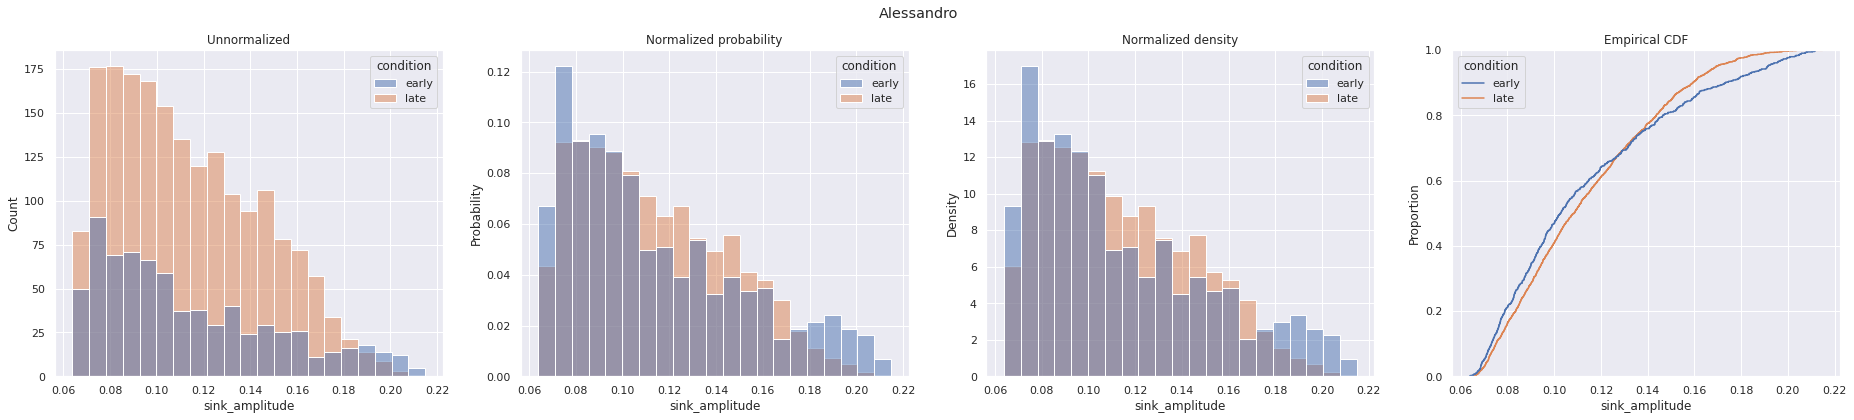

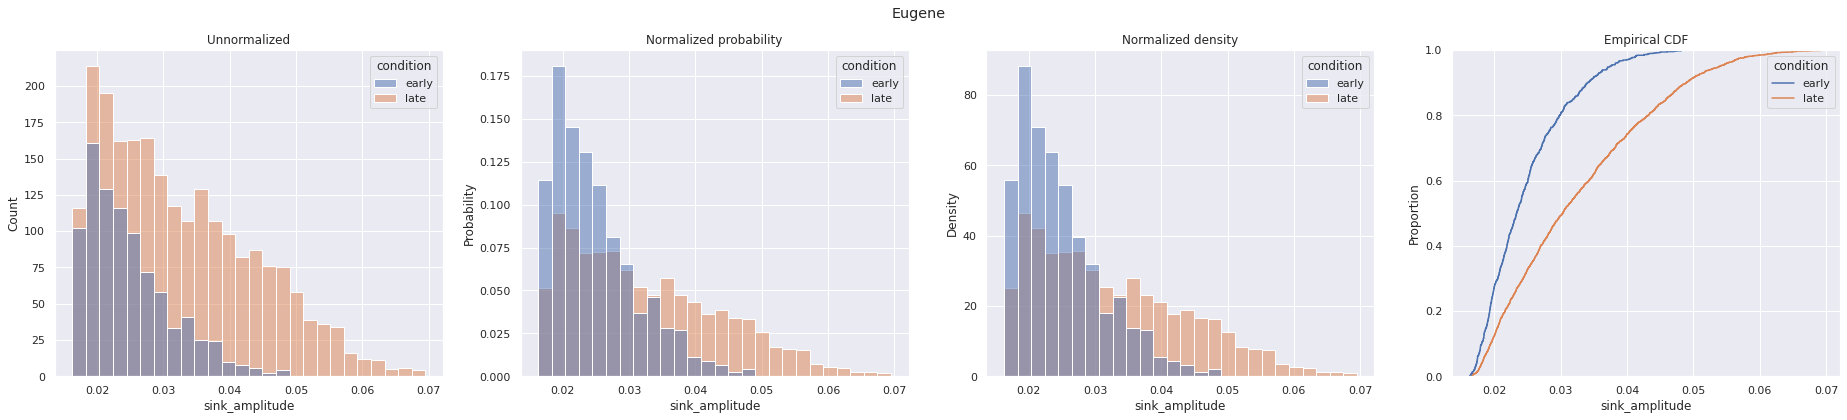

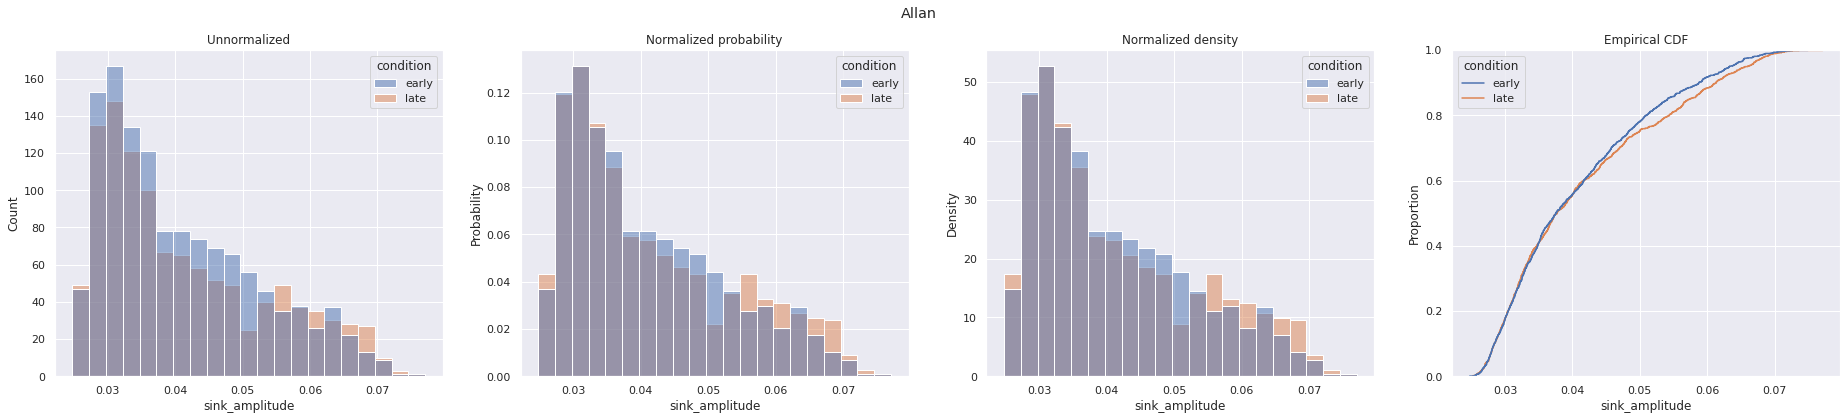

In [30]:
subjects = ["Segundo", "Valentino", "Doppio", "Alessandro", "Eugene", "Allan"]
col = 'sink_amplitude'
log_transform = False

subject_dfs = list()
for subject in subjects:
    early_hyp, early_spws = ea.load_early_deprivation(subject, abs_sink=True)
    late_hyp, late_spws = ea.load_late_deprivation(subject, abs_sink=True)
    
    df = pd.concat([early_spws[col], late_spws[col]], keys=['early', 'late'], names=['condition']).reset_index().drop(columns='spw_number')
    if log_transform:
        df[col] = np.log10(df[col])
        
    fig, axes = plt.subplots(1, 4, figsize=(32, 6))
    fig.suptitle(subject)
    sns.histplot(df, x=col, hue='condition', ax=axes[0])
    axes[0].set(title='Unnormalized')
    sns.histplot(df, x=col, hue='condition', stat='probability', common_norm=False, ax=axes[1])
    axes[1].set(title='Normalized probability')
    sns.histplot(df, x=col, hue='condition', stat='density', common_norm=False, ax=axes[2])
    axes[2].set(title='Normalized density')
    sns.ecdfplot(df, x=col, hue='condition', ax=axes[3])
    axes[3].set(title='Empirical CDF')
    
    subject_dfs.append(df)

In [31]:
from scipy import stats

df = pd.concat(subject_dfs, keys=subjects, names=['subject']).droplevel(1)
means = df.groupby(['subject', 'condition']).mean()
diff_means = means.xs((slice(None), 'late')) - means.xs((slice(None), 'early'))

print('Difference of means (late - early)')
print(diff_means.to_markdown())
print(stats.ttest_1samp(diff_means, 0))

Difference of means (late - early)
| subject    |   sink_amplitude |
|:-----------|-----------------:|
| Alessandro |     -0.000298108 |
| Allan      |      0.000766851 |
| Doppio     |      0.00357214  |
| Eugene     |      0.00771271  |
| Segundo    |      0.0105182   |
| Valentino  |      0.00209038  |
Ttest_1sampResult(statistic=array([2.35730575]), pvalue=array([0.06496796]))


In [32]:
df = pd.concat(subject_dfs, keys=subjects, names=['subject']).droplevel(1)
medians = df.groupby(['subject', 'condition']).median()
diff_medians = medians.xs((slice(None), 'late')) - medians.xs((slice(None), 'early'))

print('Difference of medians (late - early)')
print(diff_medians.to_markdown())
print(stats.ttest_1samp(diff_medians, 0))

Difference of medians (late - early)
| subject    |   sink_amplitude |
|:-----------|-----------------:|
| Alessandro |      0.00581182  |
| Allan      |      0.000158363 |
| Doppio     |      0.00239385  |
| Eugene     |      0.00695547  |
| Segundo    |      0.00871826  |
| Valentino  |      0.00141242  |
Ttest_1sampResult(statistic=array([3.05159751]), pvalue=array([0.02837255]))


In [55]:
print()
for subject_df, subject in zip(subject_dfs, subjects):
    early = subject_df.set_index('condition').xs('early')
    late = subject_df.set_index('condition').xs('late')
    ks = stats.ks_2samp(early.values.flatten(), late.values.flatten(), alternative='greater')
    print(f"{subject}: {ks}")
    print()


Segundo: KstestResult(statistic=0.21289412295883814, pvalue=9.8264734065618e-21)

Valentino: KstestResult(statistic=0.07084809302674895, pvalue=0.004372768035789208)

Doppio: KstestResult(statistic=0.0880200864404079, pvalue=0.002346861007694682)

Alessandro: KstestResult(statistic=0.0684172223538571, pvalue=0.006294324871204525)

Eugene: KstestResult(statistic=0.3183207935019059, pvalue=5.477867452799223e-57)

Allan: KstestResult(statistic=0.05560716368899739, pvalue=0.023468203505265215)

